# Temat testów:

### Czy istnieje istotna statystycznie różnica w poprawności odpowiedzi w zależności od czasu odpowiedzi i trudności zadania? (grupy: wszystkie grafiki, grafiki A, grafiki B, grafiki 1,2,3)

In [1]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_corr = pd.read_csv('/Users/martasolarz/Studies/Thesis/data/correctness.csv',
    usecols=['ID', '1a_trud', '1b_trud', '2a_trud', '2b_trud', '3a_trud', '3b_trud', '1a_corr', '1b_corr', '2a_corr', '2b_corr', '3a_corr', '3b_corr']
)

df_corr = df_corr[df_corr.ID != 6] # odrzucony uczestnik ze względu na metryki eye trackingowe

df_time =  pd.read_csv('/Users/martasolarz/Studies/Thesis/data/metrics/times.csv',
    usecols=['ID', 'Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b']
)

df_merge = df_corr.merge(df_time, on='ID')
df_merge.head()

,ID,1a_trud,1b_trud,2a_trud,2b_trud,3a_trud,3b_trud,1a_corr,1b_corr,2a_corr,2b_corr,3a_corr,3b_corr,Duration_1a,Duration_1b,Duration_2a,Duration_2b,Duration_3a,Duration_3b
0,1,3,1,4,3,4,4,1,1,0,0,1,1,28015,15516,54481,58697,56314,63897
1,2,1,2,3,1,2,4,1,1,1,1,0,1,66230,88463,42248,85329,47948,129427
2,3,2,1,3,1,1,1,1,1,1,1,0,0,68830,83963,45165,32732,8000,61197
3,4,3,2,2,1,3,5,1,1,1,1,1,0,46048,78446,12449,37715,60980,101795
4,5,4,2,3,2,3,3,1,1,1,1,1,1,67980,27582,55931,22132,34898,62930


Funkcje:

In [3]:
def prepate_set(list_of_cols_czas, list_of_cols_trud, list_of_cols_popr):
    new_row_czas = list_of_cols_czas[0]
    for i in list_of_cols_czas[1:]:
        new_row_czas = pd.concat([new_row_czas, i], ignore_index=True)

    new_row_trud = list_of_cols_trud[0]
    for i in list_of_cols_trud[1:]:
        new_row_trud = pd.concat([new_row_trud, i], ignore_index=True)
        
    new_row_popr = list_of_cols_popr[0]
    for i in list_of_cols_popr[1:]:
        new_row_popr = pd.concat([new_row_popr, i], ignore_index=True)

    return pd.DataFrame({'trudnosc': new_row_trud, 'czas': new_row_czas, 'poprawnosc': new_row_popr}) 

In [4]:
def make_decision(p_val, alpha):
    print('--------------------------------------------------------')
    print('p-value: ', p_val)
    if p_val < alpha:
        print('Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.')
    else:
        print('Brak podstaw do odrzucenia H0.')
    print('--------------------------------------------------------')

def conduct_logistic_regression(df, alpha):
    X = df[['czas', 'trudnosc']] # zmienne niezależne
    y = df['poprawnosc'] # zmienna zależna

    # Tworzenie modelu regresji logistycznej
    model = sm.Logit(y, X)

    # Dopasowanie modelu
    result = model.fit()

    print('Trudność: ')
    make_decision(result.pvalues['trudnosc'], alpha)
    print('Czas: ')
    make_decision(result.pvalues['czas'], alpha)
    print(result.summary())

In [5]:
def create_plots(df):
    # Tworzenie wykresu punktowego
    plt.scatter(df['czas'], df['poprawnosc'])
    plt.xlabel('Czas')
    plt.ylabel('Poprawność')
    plt.title('Wykres poprawności w zależności od czasu')
    plt.grid()
    plt.show()

    # Tworzenie wykresu krzywej ROC
    logit_model = sm.Logit(df['poprawnosc'], sm.add_constant(df['trudnosc']))
    result = logit_model.fit(disp=0)
    y_pred = result.predict(sm.add_constant(df['trudnosc']))
    fpr, tpr, _ = roc_curve(df['poprawnosc'], y_pred)
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Wykres krzywej ROC')
    plt.grid()
    plt.show()

    # Tworzenie wykresu reszt
    y_pred_binary = (y_pred > 0.5).astype(int)
    residuals = df['poprawnosc'] - y_pred_binary
    plt.scatter(df['trudnosc'], residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Trudność')
    plt.ylabel('Reszty')
    plt.title('Wykres reszt')
    plt.grid()
    plt.show()

    # Wykresy warunkowych efektów
    sns.lmplot(x='trudnosc', y='poprawnosc', data=df, logistic=True, y_jitter=.03)
    plt.title('Wykres warunkowych efektów')
    plt.xlabel('Trudność')
    plt.ylabel('Poprawność')
    plt.grid()
    plt.show()


**H0:** Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi i trudnością zadania.
**H1:** Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi i trudnością zadania.
**Poziom istotności:** $\alpha=0.05$

Mamy do czynienia ze zmienną zależną ciągłą (czas) i dyskretną (trudność) oraz dyskretną zmienną niezależną (poprawność), zatem stosujemy regresję logistyczną.

In [6]:
ALPHA = 0.05

a) wszystkie grafiki

In [7]:
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('trud'):
        trud.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration'):
        czas.append(df_merge[col])
        
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('corr'):
        popr.append(df_merge[col])
        
df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
235,2,55214,1
236,3,113828,0
237,3,93112,0
238,2,35898,0
239,3,119944,0


In [8]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.632703
         Iterations 4
Trudność: 
--------------------------------------------------------
p-value:  0.11307088060026768
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.4217494869808839
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  240
Model:                          Logit   Df Residuals:                      238
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                -0.04184
Time:                        20:04:58   Log-Likelihood:                -151.85
converged:                       True   LL-Null:         

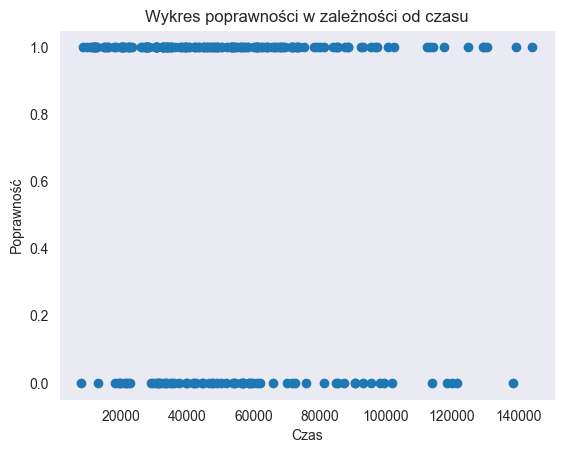

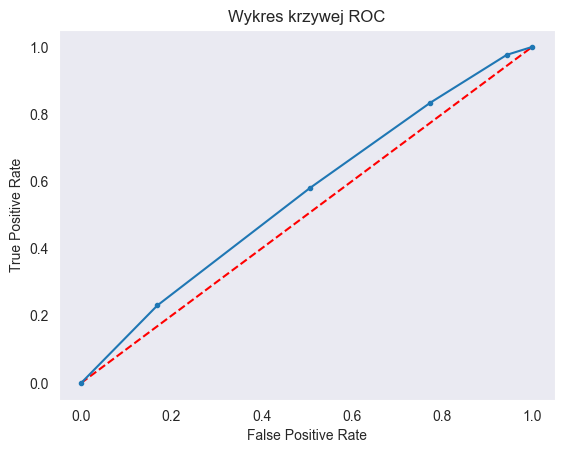

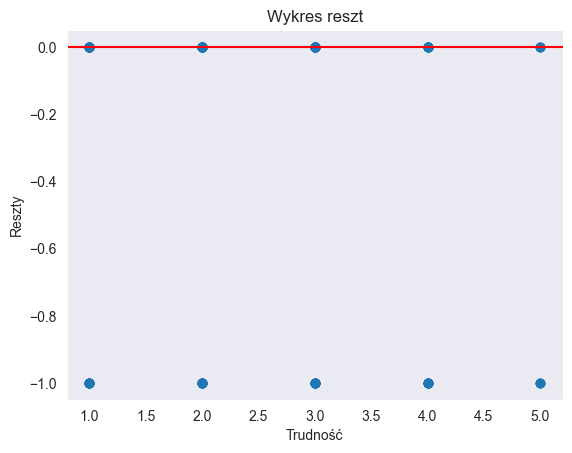

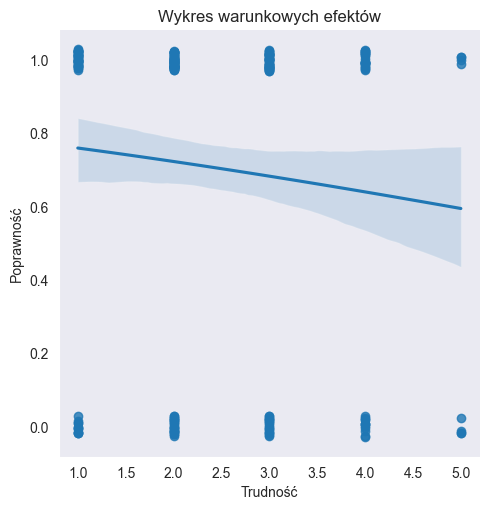

In [9]:
create_plots(df)

b) grafiki A

In [11]:
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('a_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('a'):
        czas.append(df_merge[col])
        
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('a_trud'):
        trud.append(df_merge[col])

df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
115,2,42131,0
116,3,27199,1
117,2,19382,0
118,2,49298,1
119,2,67997,1


In [12]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.616009
         Iterations 5
Trudność: 
--------------------------------------------------------
p-value:  0.05995416999012461
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.8318853110638139
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                -0.02050
Time:                        20:05:45   Log-Likelihood:                -73.921
converged:                       True   LL-Null:         

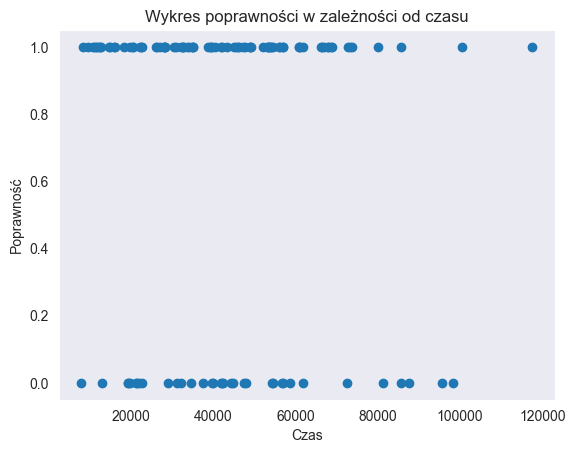

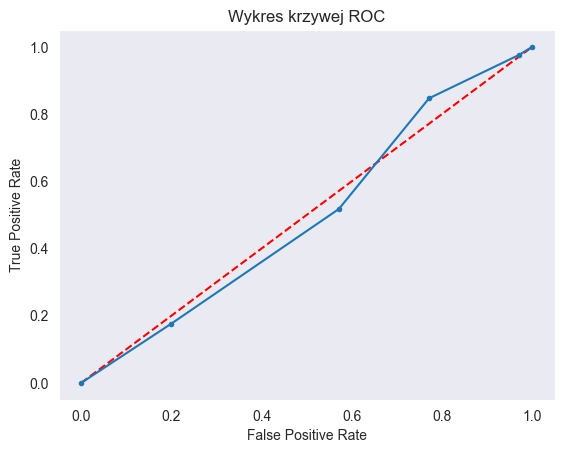

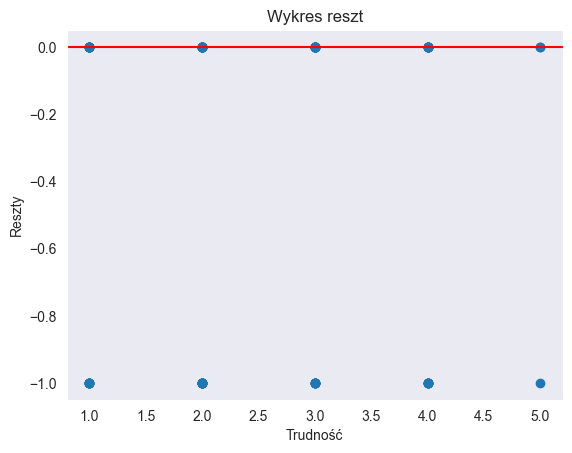

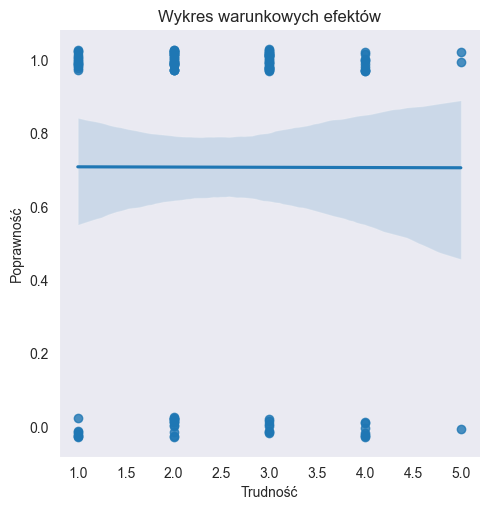

In [13]:
create_plots(df)

c) grafiki B

In [15]:
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('b_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('b'):
        czas.append(df_merge[col])
        
trud = []
for col in df_merge.columns.tolist():
    if col.endswith('b_trud'):
        trud.append(df_merge[col])

df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
115,2,55214,1
116,3,113828,0
117,3,93112,0
118,2,35898,0
119,3,119944,0


In [16]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.639638
         Iterations 5
Trudność: 
--------------------------------------------------------
p-value:  0.920404680467678
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.1299830979762918
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                -0.04710
Time:                        20:06:28   Log-Likelihood:                -76.757
converged:                       True   LL-Null:           

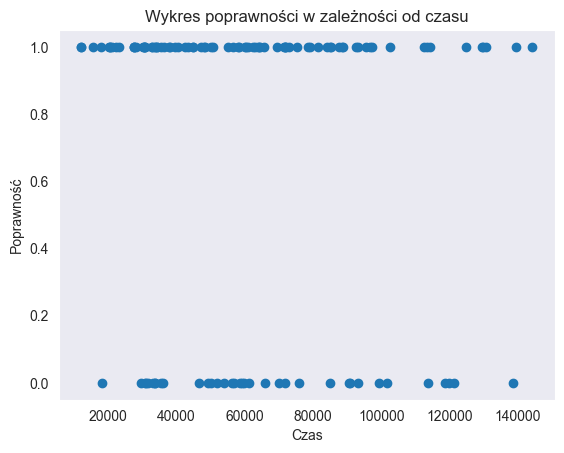

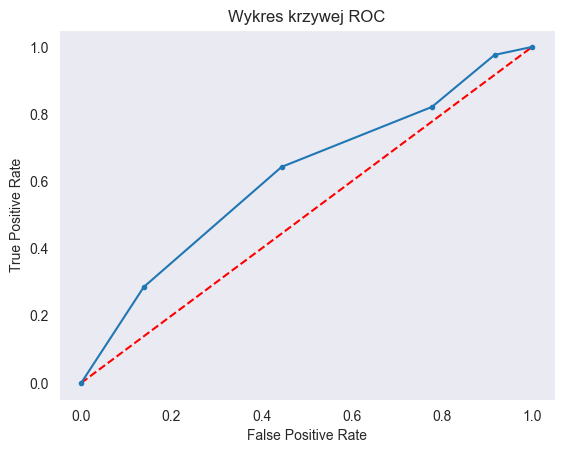

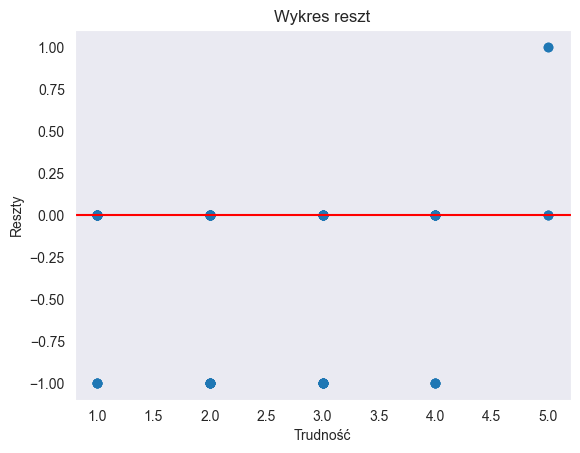

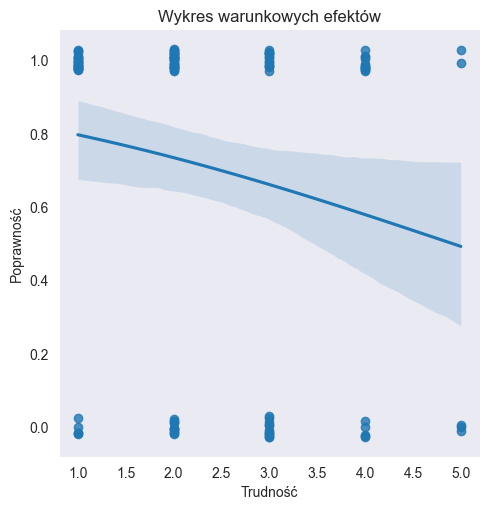

In [17]:
create_plots(df)

d) grafiki 1,2,3

-> 1

In [18]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('1') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_1'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('1') and col.endswith('_trud'):
        trud.append(df_merge[col])
        
df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
75,1,58347,1
76,2,64430,1
77,1,32732,1
78,1,47031,1
79,3,96628,1


In [19]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.328303
         Iterations 6
Trudność: 
--------------------------------------------------------
p-value:  0.22146964657864943
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.13641280777270573
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:               -0.009907
Time:                        20:07:10   Log-Likelihood:                -26.264
converged:                       True   LL-Null:        

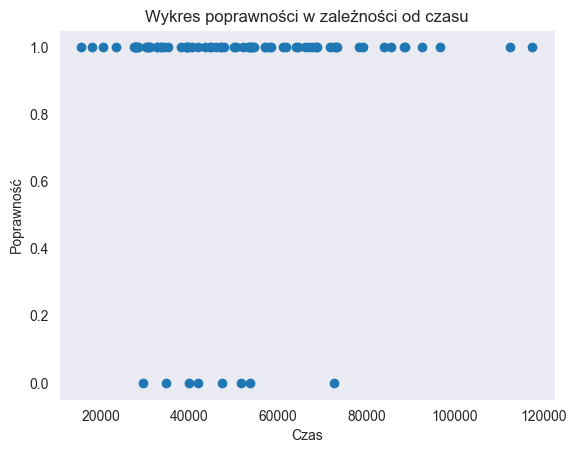

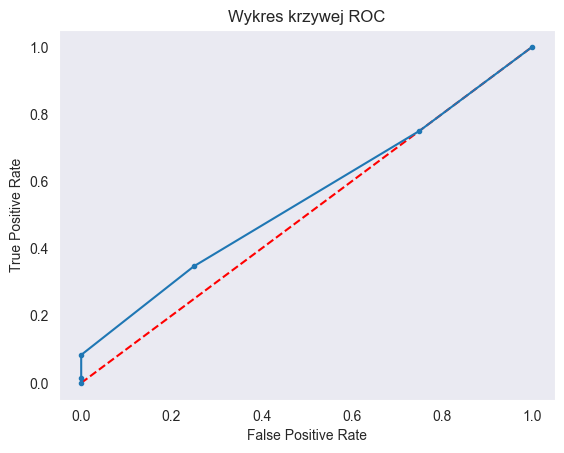

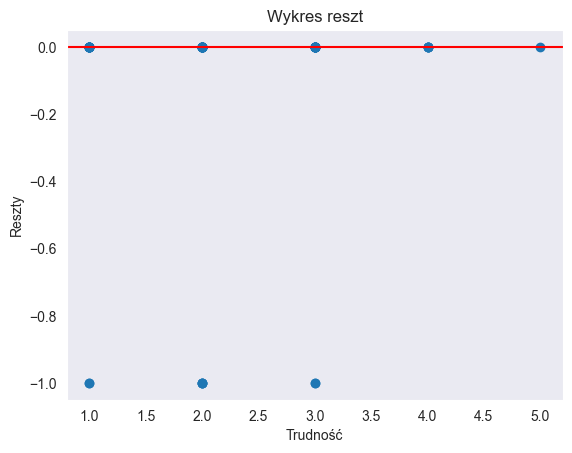

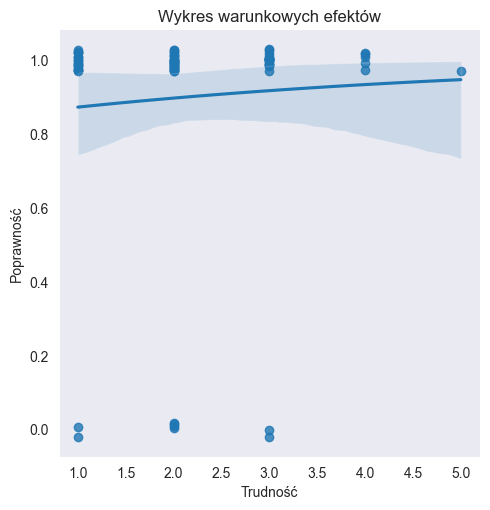

In [20]:
create_plots(df)

-> 2

In [22]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('2') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_2'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('2') and col.endswith('_trud'):
        trud.append(df_merge[col])
        
df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
75,1,34215,1
76,2,69413,1
77,1,60964,1
78,2,31582,0
79,2,113378,1


In [23]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.674864
         Iterations 4
Trudność: 
--------------------------------------------------------
p-value:  0.596027567041221
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.7841750430871833
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                 -0.1250
Time:                        20:07:42   Log-Likelihood:                -53.989
converged:                       True   LL-Null:           

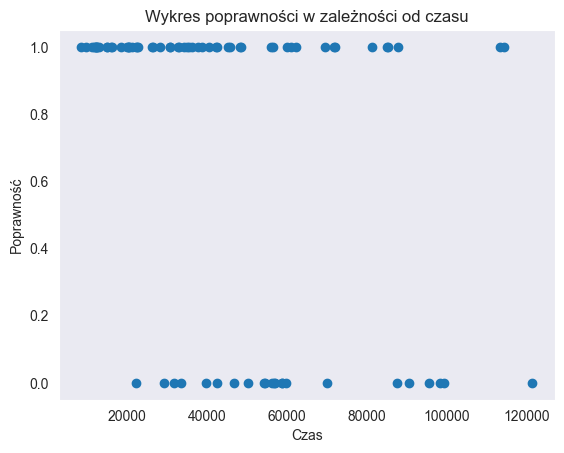

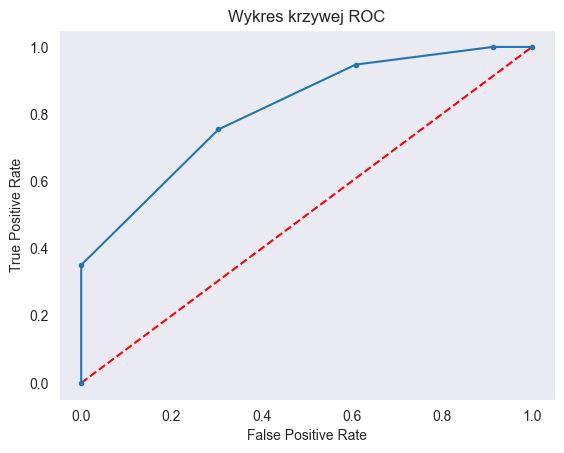

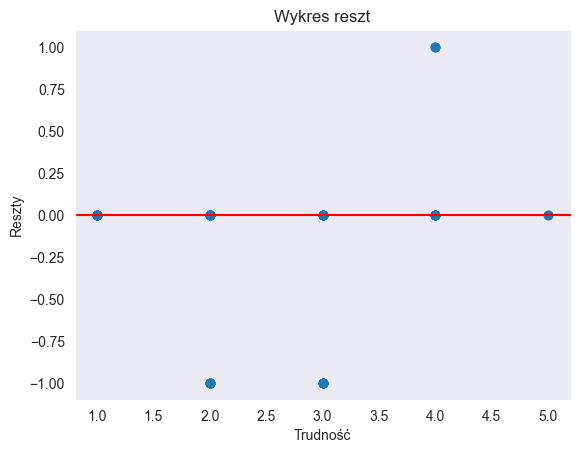

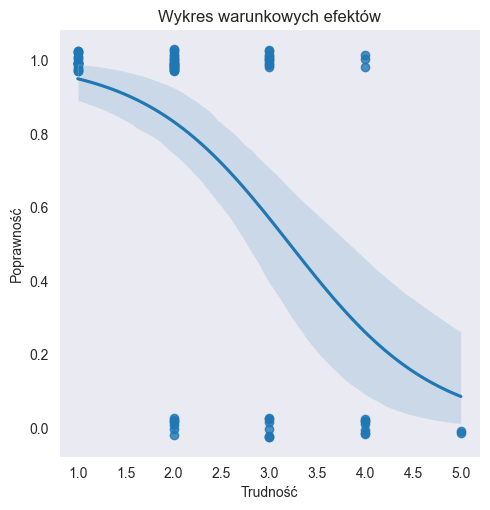

In [24]:
create_plots(df)

-> 3

In [25]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('3') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_3'):
        czas.append(df_merge[col])

trud = []
for col in df_merge.columns.tolist():
    if col.startswith('3') and col.endswith('_trud'):
        trud.append(df_merge[col])
    
df = prepate_set(czas, trud, popr)
df.tail()

,trudnosc,czas,poprawnosc
75,2,55214,1
76,3,113828,0
77,3,93112,0
78,2,35898,0
79,3,119944,0


In [26]:
conduct_logistic_regression(df, ALPHA)

Optimization terminated successfully.
         Current function value: 0.678726
         Iterations 4
Trudność: 
--------------------------------------------------------
p-value:  0.2296456991771365
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.4838820446446114
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                 0.02081
Time:                        20:08:20   Log-Likelihood:                -54.298
converged:                       True   LL-Null:          

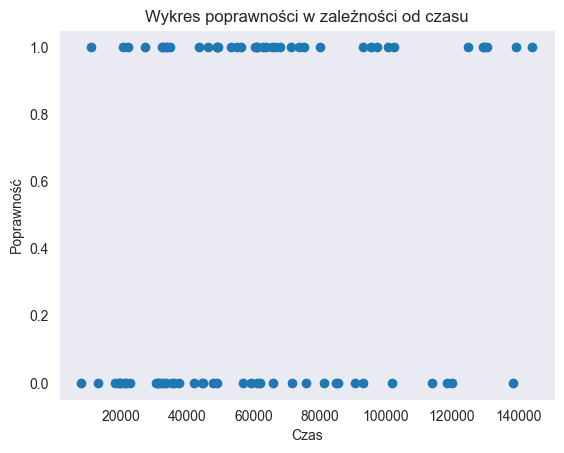

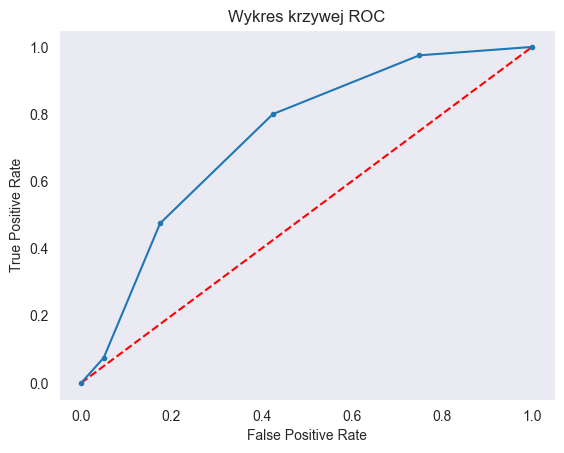

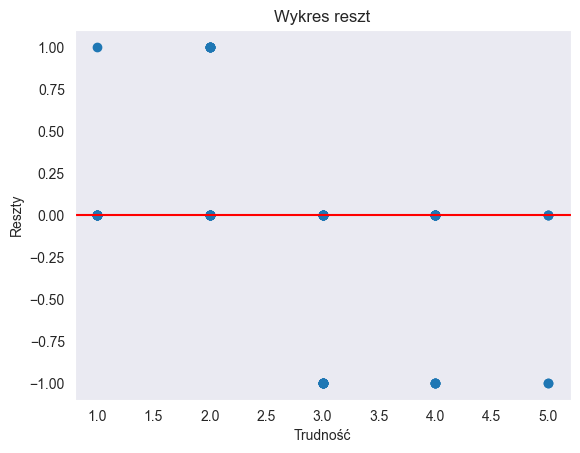

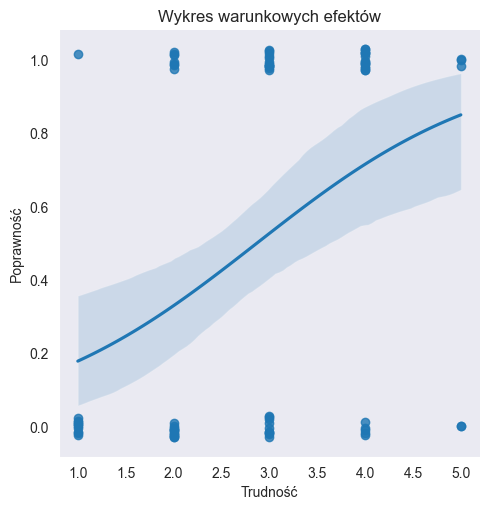

In [27]:
create_plots(df)

e) zadania 1a, 1b, 2a, 2b, 3a, 3b

In [29]:
df1a = pd.DataFrame({'czas': df_merge['Duration_1a'], 'poprawnosc': df_merge['1a_corr'], 'trudnosc': df_merge['1a_trud']})
df2a = pd.DataFrame({'czas': df_merge['Duration_2a'], 'poprawnosc': df_merge['2a_corr'], 'trudnosc': df_merge['2a_trud']})
df3a = pd.DataFrame({'czas': df_merge['Duration_3a'], 'poprawnosc': df_merge['3a_corr'], 'trudnosc': df_merge['3a_trud']})

df1b = pd.DataFrame({'czas': df_merge['Duration_1b'], 'poprawnosc': df_merge['1b_corr'],'trudnosc': df_merge['1b_trud']})
df2b = pd.DataFrame({'czas': df_merge['Duration_2b'], 'poprawnosc': df_merge['2b_corr'],'trudnosc': df_merge['2b_trud']})
df3b = pd.DataFrame({'czas': df_merge['Duration_3b'], 'poprawnosc': df_merge['3b_corr'], 'trudnosc': df_merge['3b_trud']})

dfs = [df1a, df1b, df2a, df2b, df3a, df3b]

In [30]:
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(f"{i+1}:")
    conduct_logistic_regression(df, ALPHA)

-------------------------------------
1:
Optimization terminated successfully.
         Current function value: 0.368063
         Iterations 6
Trudność: 
--------------------------------------------------------
p-value:  0.4961873162463245
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
Czas: 
--------------------------------------------------------
p-value:  0.284121506215006
Brak podstaw do odrzucenia H0.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                 0.02311
Time:                        20:10:01   Log-Likelihood:                -14.723
converged:        

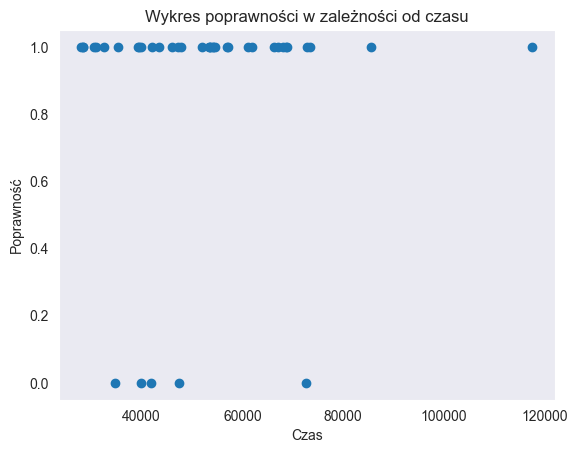

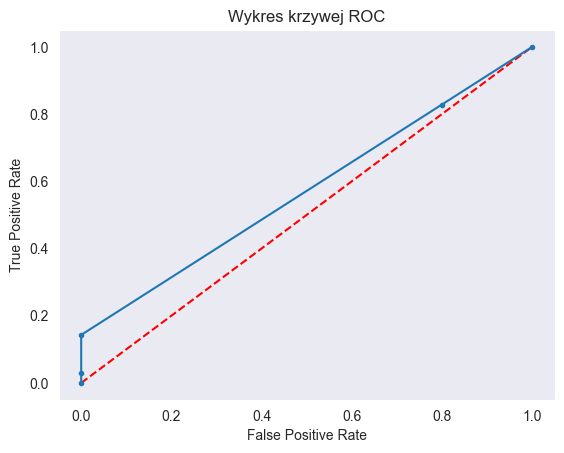

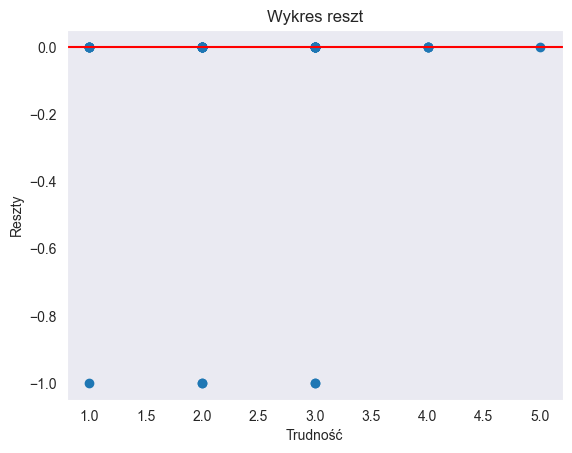

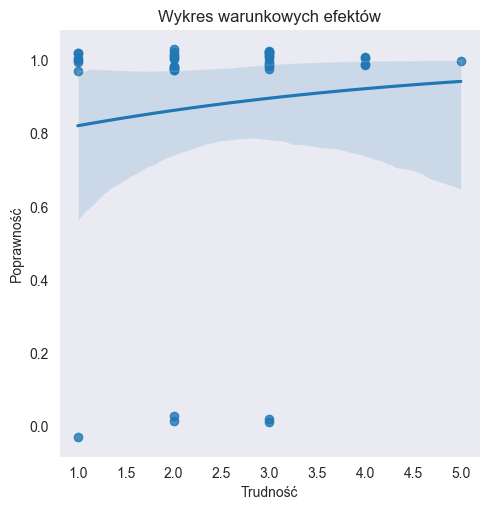

In [31]:
create_plots(df1a)

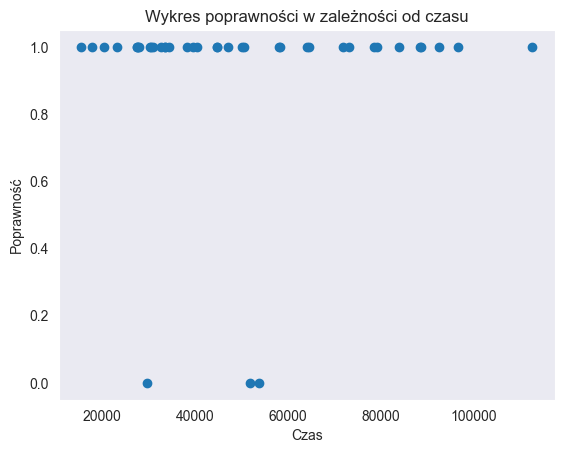

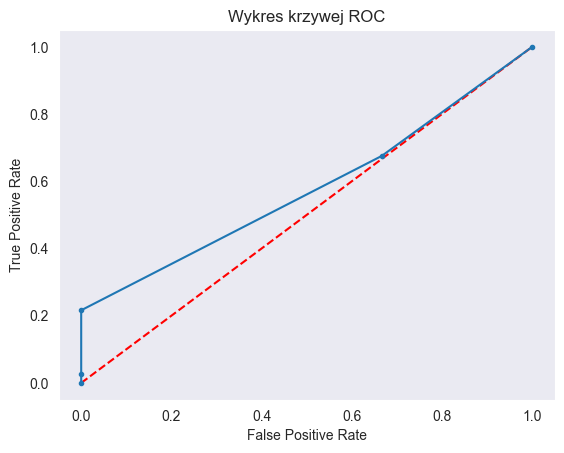

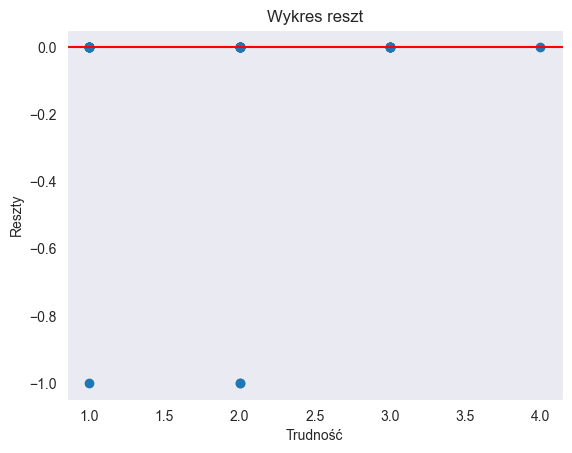

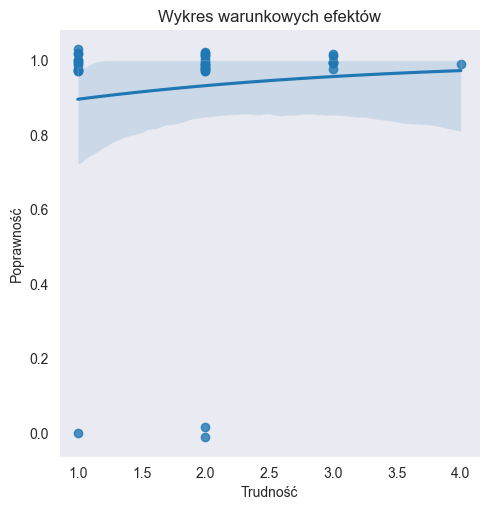

In [32]:
create_plots(df1b)

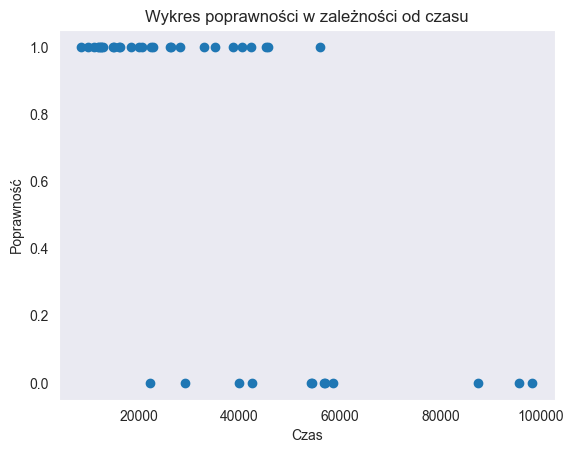

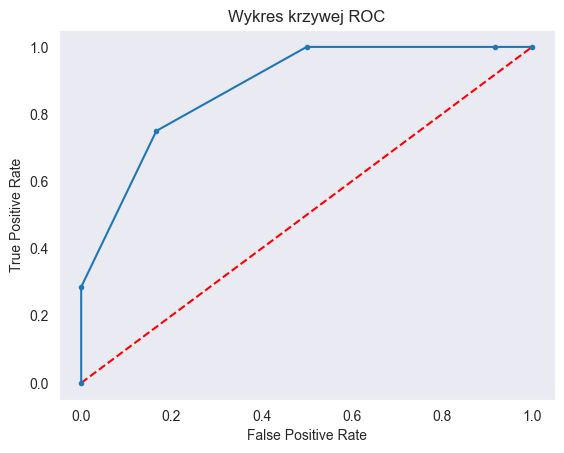

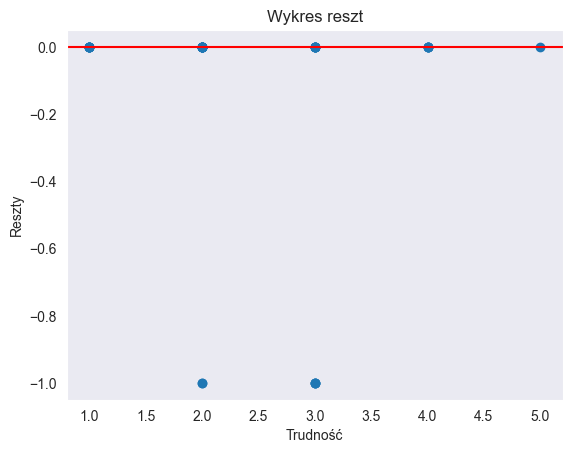

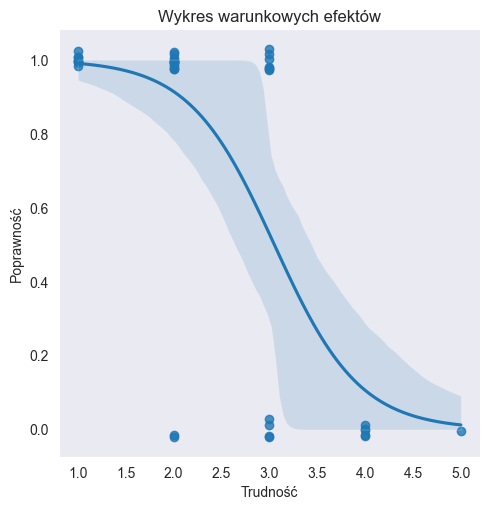

In [33]:
create_plots(df2a)

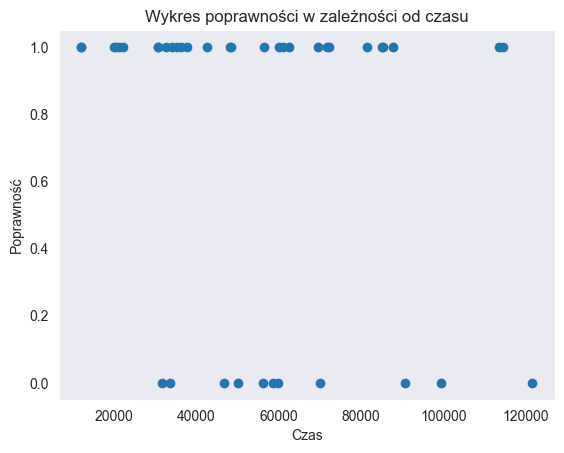

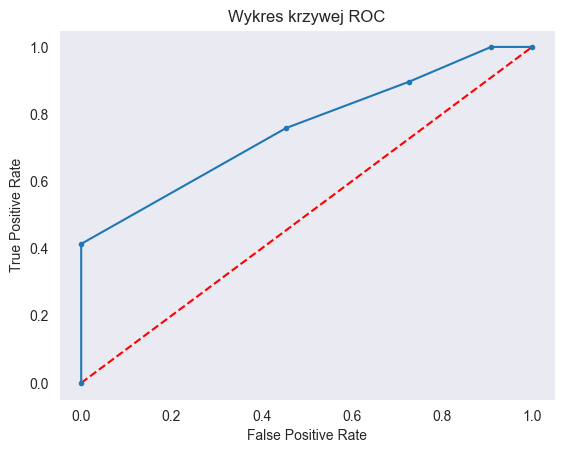

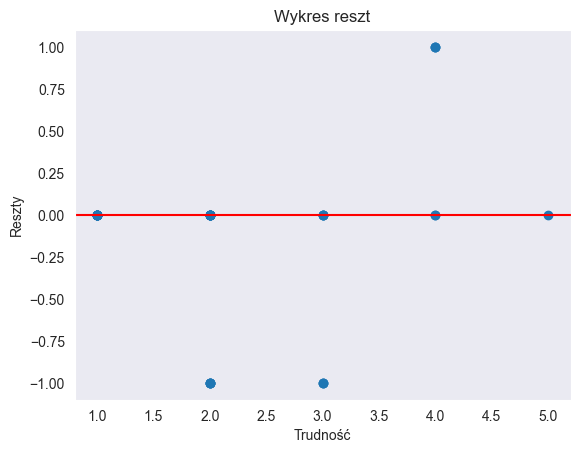

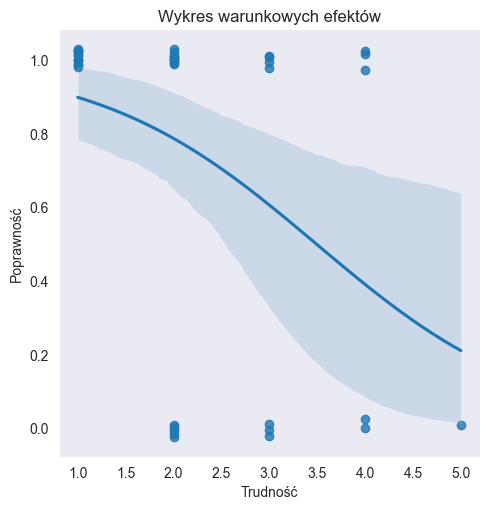

In [34]:
create_plots(df2b)

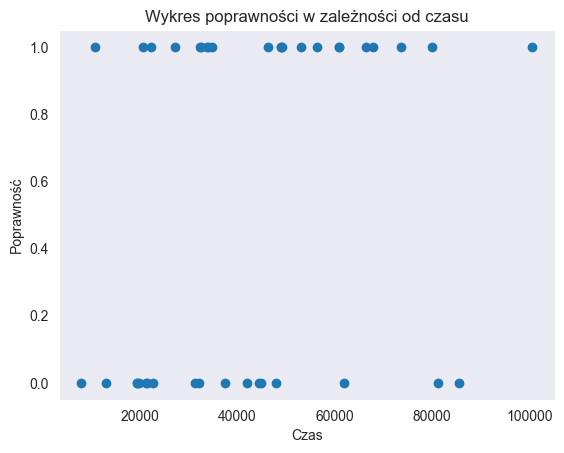

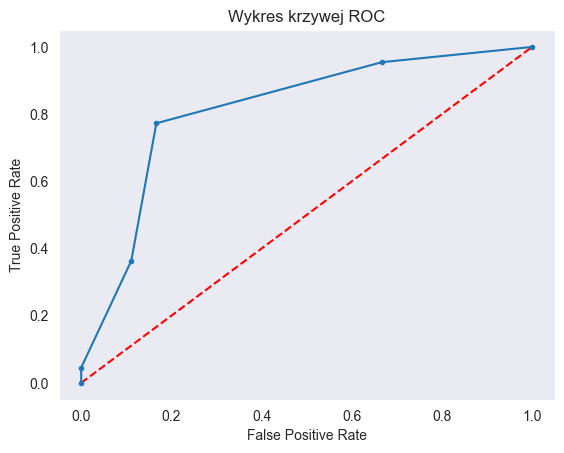

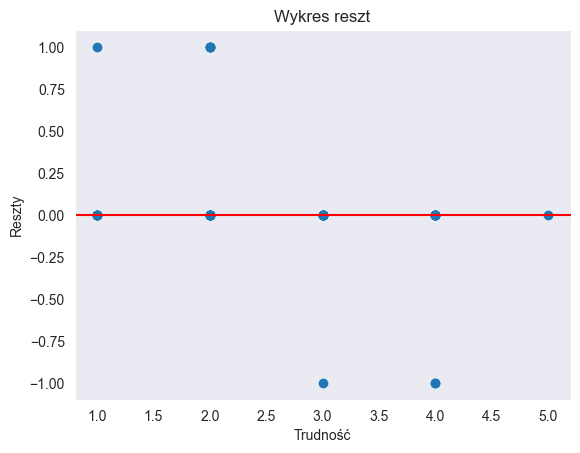

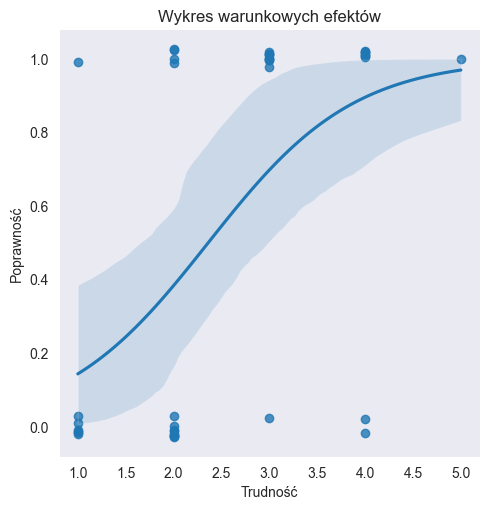

In [35]:
create_plots(df3a)

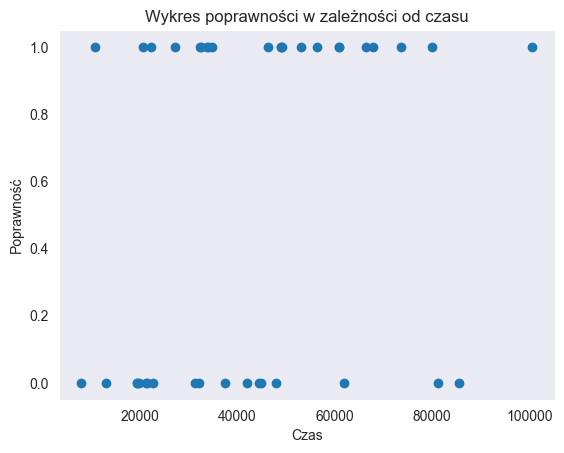

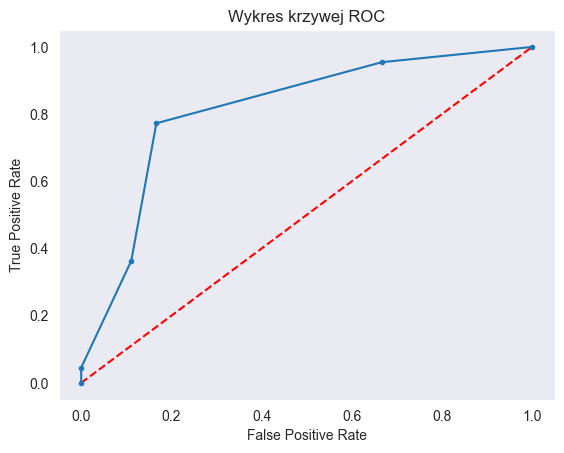

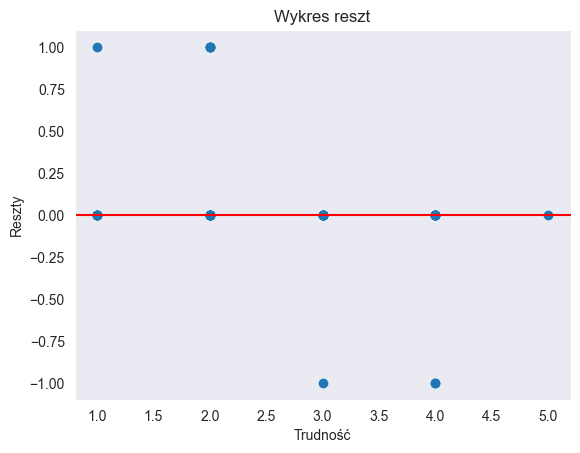

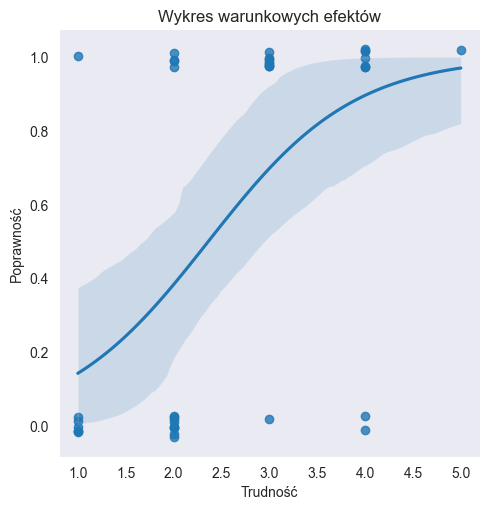

In [36]:
create_plots(df3a)

### Podsumowanie:
Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi i trudności zadania na poziomie istotności $\alpha=0.05$ dla:

- grafiki 2a
